# Online Payments Fraud Detection with Machine Learning
Online payment frauds can happen with anyone using any payment system, especially while making payments using a credit card. That is why detecting online payment fraud is very important for credit card companies to ensure that the customers are not getting charged for the products and services they never paid

# Importing Libraries

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Read Data
1. step: represents a unit of time where 1 step equals 1 hour
2. type: type of online transaction
3. amount: the amount of the transaction
4. nameOrig: customer starting the transaction
5. oldbalanceOrg: balance before the transaction
6. newbalanceOrig: balance after the transaction
7. nameDest: recipient of the transaction
8. oldbalanceDest: initial balance of recipient before the transaction
9. newbalanceDest: the new balance of recipient after the transaction
10. isFraud: fraud transaction

In [139]:
data = pd.read_csv('C:/Users/Reskur/Documents/Python/DS_project/fraud_ds.csv', skipinitialspace=True, nrows=500000)
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0
5,1,PAYMENT,"7,817.71",C90045638,"53,860.00","46,042.29",M573487274,0.00,0.00,0,0
6,1,PAYMENT,"7,107.77",C154988899,"183,195.00","176,087.23",M408069119,0.00,0.00,0,0
7,1,PAYMENT,"7,861.64",C1912850431,"176,087.23","168,225.59",M633326333,0.00,0.00,0,0
8,1,PAYMENT,"4,024.36",C1265012928,"2,671.00",0.00,M1176932104,0.00,0.00,0,0
9,1,DEBIT,"5,337.77",C712410124,"41,720.00","36,382.23",C195600860,"41,898.00","40,348.79",0,0


In [140]:
data.shape

(500000, 11)

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   nameOrig        500000 non-null  object 
 4   oldbalanceOrg   500000 non-null  float64
 5   newbalanceOrig  500000 non-null  float64
 6   nameDest        500000 non-null  object 
 7   oldbalanceDest  500000 non-null  float64
 8   newbalanceDest  500000 non-null  float64
 9   isFraud         500000 non-null  int64  
 10  isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 42.0+ MB


In [142]:
data.nunique()

step                  20
type                   5
amount            491657
nameOrig          499953
oldbalanceOrg     229742
newbalanceOrig    225017
nameDest          214856
oldbalanceDest    292284
newbalanceDest    168174
isFraud                2
isFlaggedFraud         1
dtype: int64

In [143]:
data.describe().style.background_gradient()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,13.906728,166393.688002,911692.845658,931426.115600,982773.864254,1162668.163322,0.000466,0.000000
std,3.731891,272584.079811,3016900.517869,3054014.762081,2336426.059350,2510610.399728,0.021582,0.000000
min,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,13350.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,81375.600000,18569.000000,0.000000,119271.125000,222144.150000,0.000000,0.000000
75%,17.000000,222644.100000,170294.072500,210171.597500,896226.685000,1201403.380000,0.000000,0.000000
max,20.000000,10000000.000000,38939424.030000,38946233.020000,41482697.120000,41482697.120000,1.000000,0.000000


In [144]:
dups = data.duplicated()
print(dups.any)
print(data[dups])

<bound method NDFrame._add_numeric_operations.<locals>.any of 0         False
1         False
2         False
3         False
4         False
          ...  
499995    False
499996    False
499997    False
499998    False
499999    False
Length: 500000, dtype: bool>
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud]
Index: []


# Data Visualization
first let's see the type of transaction 

In [145]:
data['type'].value_counts()

CASH_OUT    182316
PAYMENT     164032
CASH_IN     109319
TRANSFER     40730
DEBIT         3603
Name: type, dtype: int64

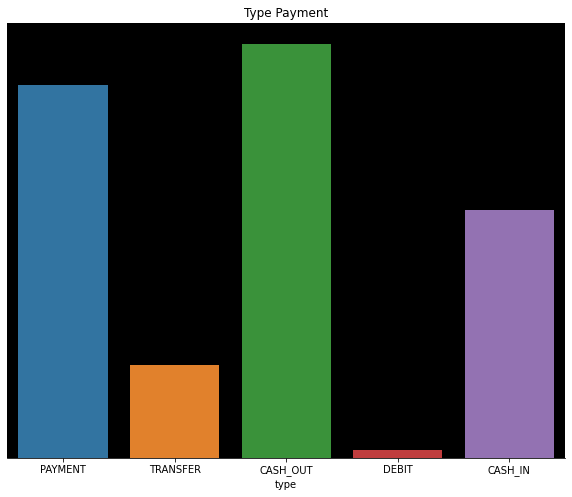

In [146]:
plt.figure(figsize=(10,8))
ax = sns.countplot(data=data, x='type')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x()+p.get_width()/2., p.get_height()),
               ha='center',
               va='center',
               xytext=(0,10),
               textcoords='offset points')
    sns.despine(right=True, top=True, left=True)
    ax.axes.yaxis.set_visible(False)
plt.title('Type Payment')
plt.show()

Now let’s have a look at the data distribution and box plot of amount, oldbalanceOrg, newbalanceOrig 

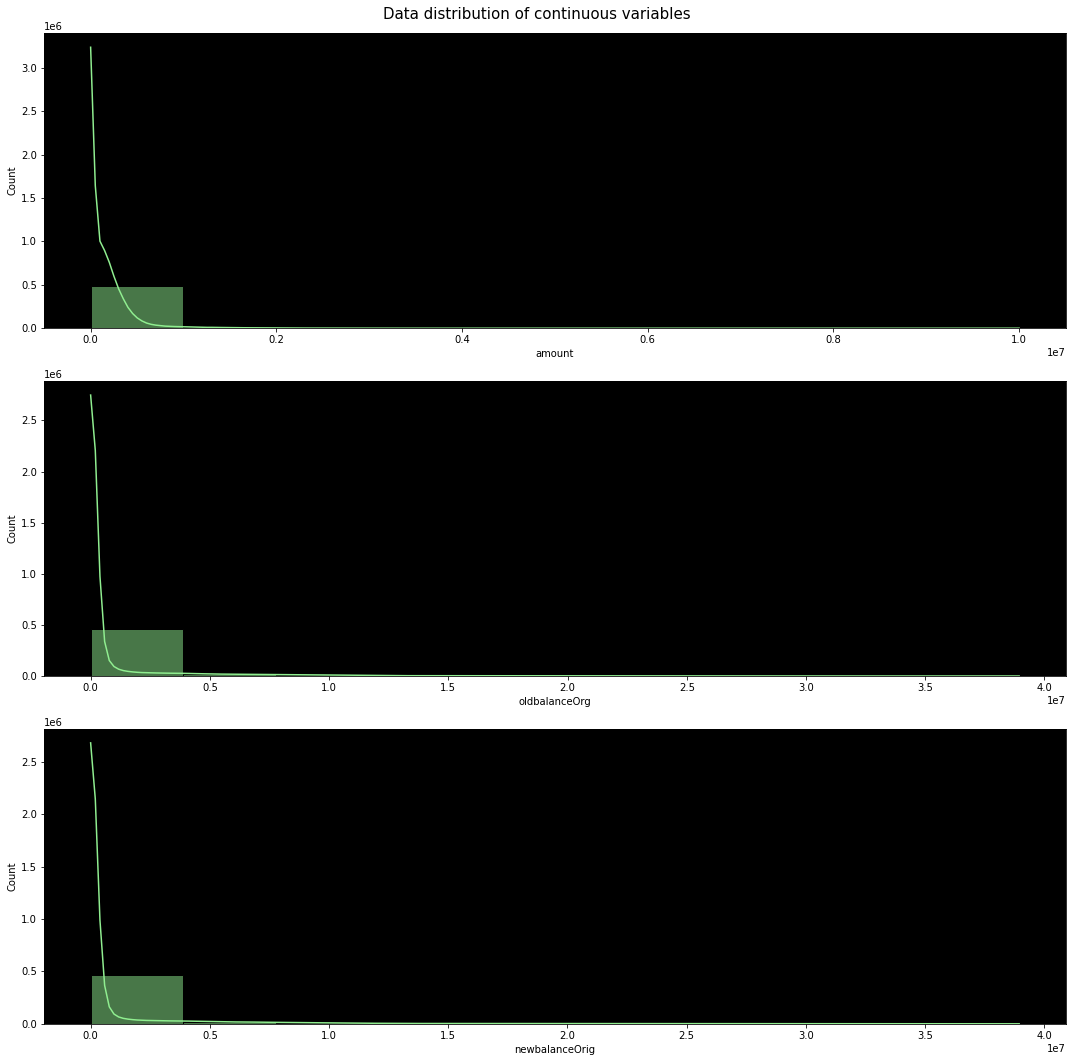

In [147]:
plot_data = ['amount', 'oldbalanceOrg', 'newbalanceOrig']
plt.figure(figsize=(15, 15))
for i, col in enumerate(plot_data):
    plt.rcParams['axes.facecolor'] = 'black'
    ax = plt.subplot(3,1, i+1)
    sns.histplot(data=data, x=col, ax=ax, color='lightgreen', bins=10, kde=True)
plt.suptitle('Data distribution of continuous variables', size=15)
plt.tight_layout()

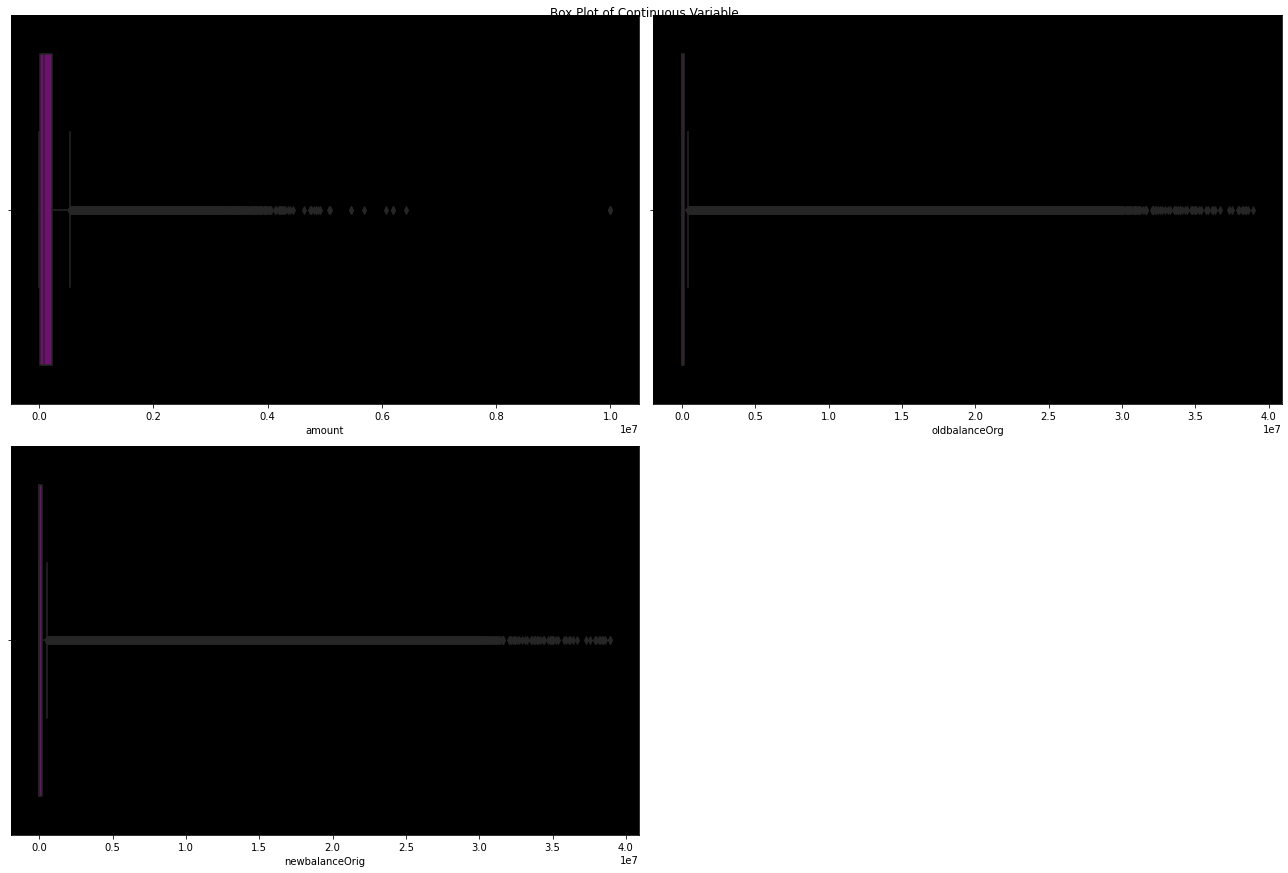

In [148]:
plt.figure(figsize=(18,18))
for i, col in enumerate(plot_data):
    plt.rcParams['axes.facecolor'] = 'black'
    ax = plt.subplot(3,2, i+1)
    sns.boxplot(data=data, x=col, ax=ax, color='purple')
plt.suptitle('Box Plot of Continuous Variable')
plt.tight_layout()
plt.show()

# Treating Outlier

we can see that our data is skew and have a lot outlier, let's remove them

In [149]:
def outlier_treating(data, var):
    data=data.copy()
    def outlier_detector(data):
        outliers = []
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        IQR = q3 - q1
        ib = q1 - (IQR*1.5)
        ub = q3 + (IQR*1.5)
        for i, j in enumerate(data):
            if (j < ib or j > ub):
                outliers.append(i)
        return outliers
    for i in var:
        out_var = outlier_detector(data[i])
        data.loc[out_var, i] = np.median(data[i])
    return data

In [150]:
var = list(data.select_dtypes(include=['float64']).columns)
data = outlier_treating(data, var)

# Marking Invalid Data as Missing Value and Remove Them

in oldbalanceOrg column there is 0 value, I think that value is invalid because we can't make a transaction if our balance is 0 or nothing, so let's mark them with NaN and remove them as missing value

In [151]:
from numpy import NaN
data['oldbalanceOrg'] = data['oldbalanceOrg'].replace(0, NaN)
print(data.isnull().sum())

step                   0
type                   0
amount                 0
nameOrig               0
oldbalanceOrg     162653
newbalanceOrig         0
nameDest               0
oldbalanceDest         0
newbalanceDest         0
isFraud                0
isFlaggedFraud         0
dtype: int64


In [152]:
pd.options.display.float_format='{:,.2f}%'.format
print((data.isnull().sum()/len(data))*100)
pd.options.display.float_format='{:,.2f}'.format

step              0.00%
type              0.00%
amount            0.00%
nameOrig          0.00%
oldbalanceOrg    32.53%
newbalanceOrig    0.00%
nameDest          0.00%
oldbalanceDest    0.00%
newbalanceDest    0.00%
isFraud           0.00%
isFlaggedFraud    0.00%
dtype: float64


In [153]:
data.dropna(inplace=True)

In [154]:
data.shape

(337347, 11)

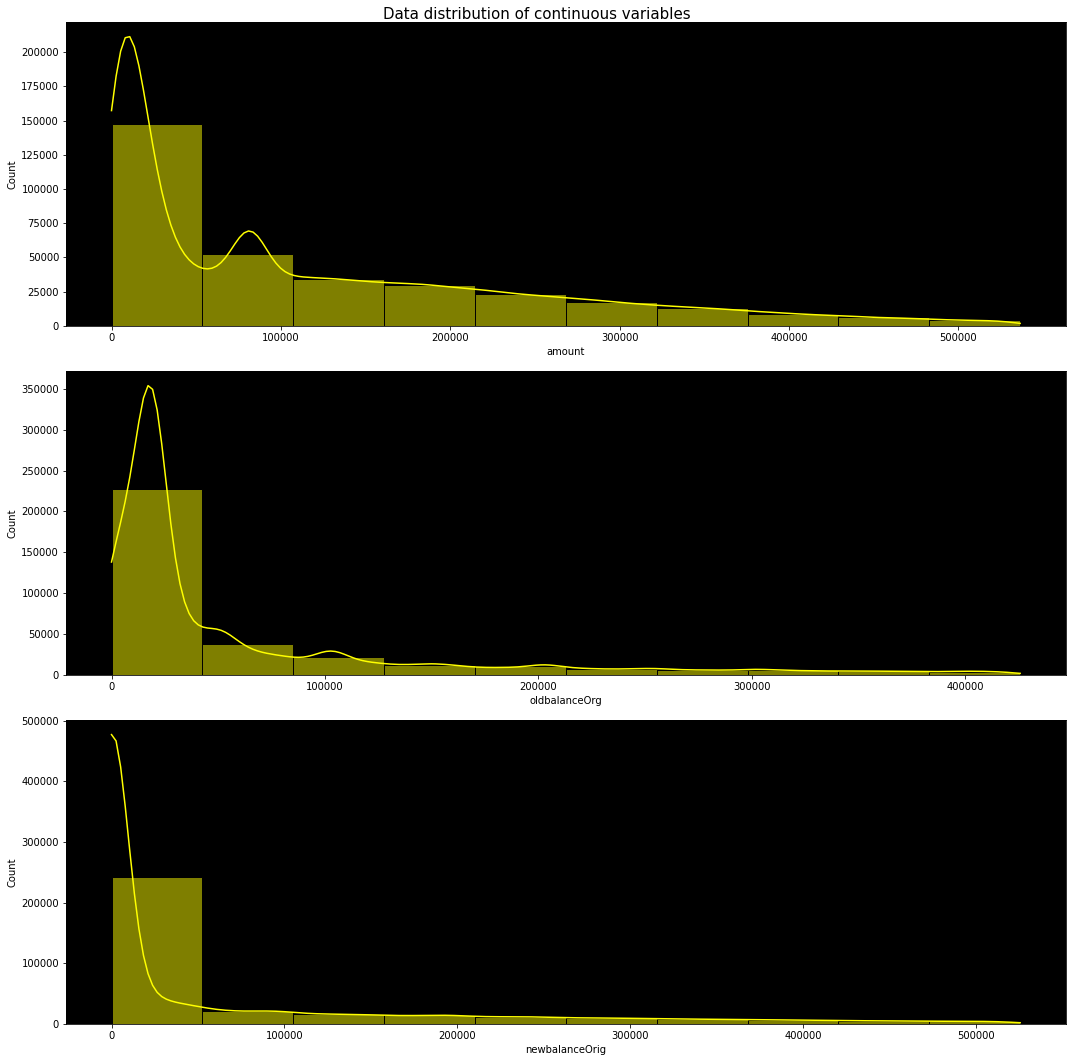

In [155]:
plot_data = ['amount', 'oldbalanceOrg', 'newbalanceOrig']
plt.figure(figsize=(15, 15))
for i, col in enumerate(plot_data):
    plt.rcParams['axes.facecolor'] = 'black'
    ax = plt.subplot(3,1, i+1)
    sns.histplot(data=data, x=col, ax=ax, color='yellow', bins=10, kde=True)
plt.suptitle('Data distribution of continuous variables', size=15)
plt.tight_layout()

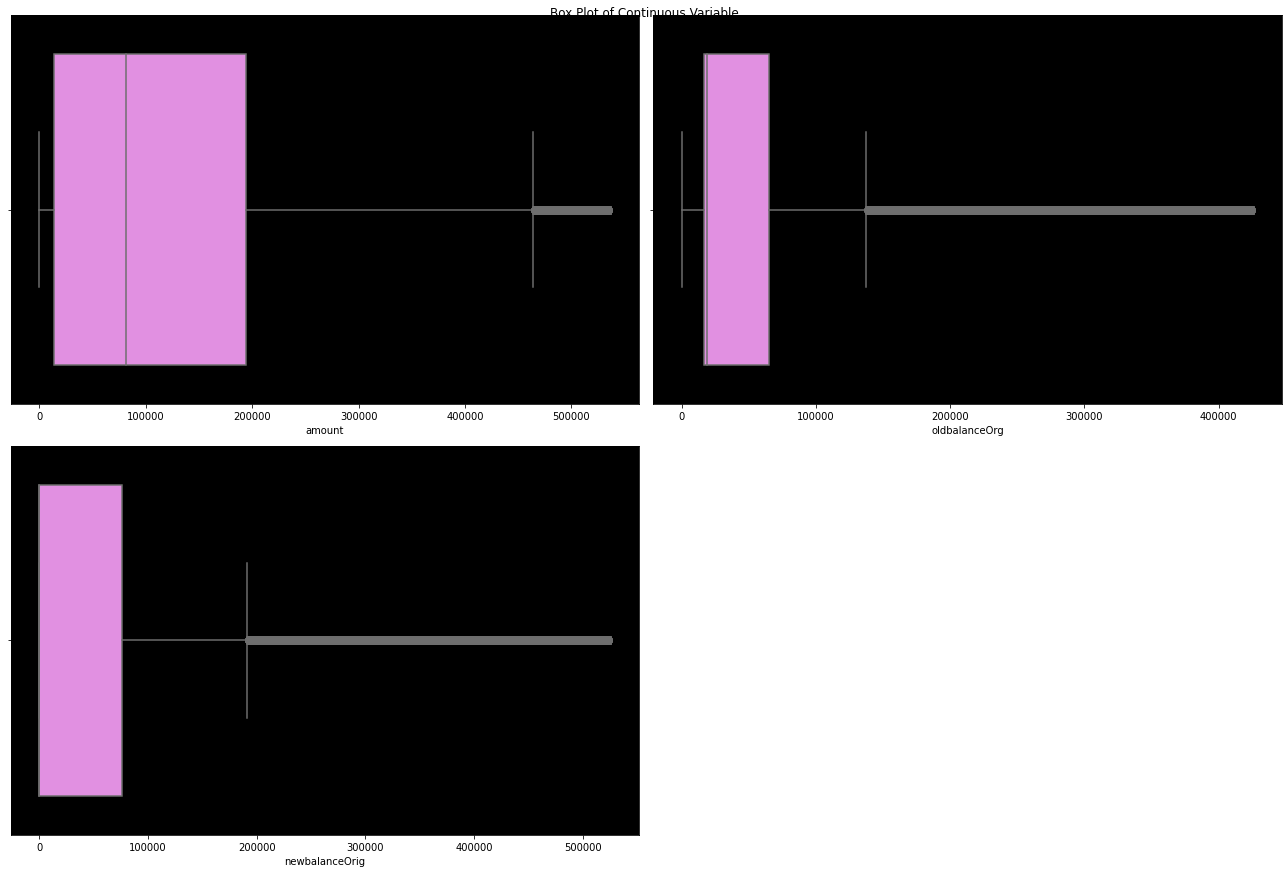

In [156]:
plt.figure(figsize=(18,18))
for i, col in enumerate(plot_data):
    plt.rcParams['axes.facecolor'] = 'black'
    ax = plt.subplot(3,2, i+1)
    sns.boxplot(data=data, x=col, ax=ax, color='violet')
plt.suptitle('Box Plot of Continuous Variable')
plt.tight_layout()
plt.show()

although our data is still skew, but it's still better than before

# Convert Categorical Data to Numerical Data

Now let’s transform the categorical features into numerical. Here I will also transform the values of the isFraud column into No Fraud and Fraud labels to have a better understanding of the output:

In [157]:
data["type"] = data["type"].map({"CASH_OUT" : 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})
data["isFraud"] = data["isFraud"].map({0: "NO FRAUD", 1: "FRAUD"})
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,NO FRAUD,0
1,1,2,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,NO FRAUD,0
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,FRAUD,0
3,1,1,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,FRAUD,0
4,1,2,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,NO FRAUD,0


# Imbalaced Target Class
Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations. We can see that our dataset highly imbalaced data, class 'No Fraud' have more data than class 'Fraud'

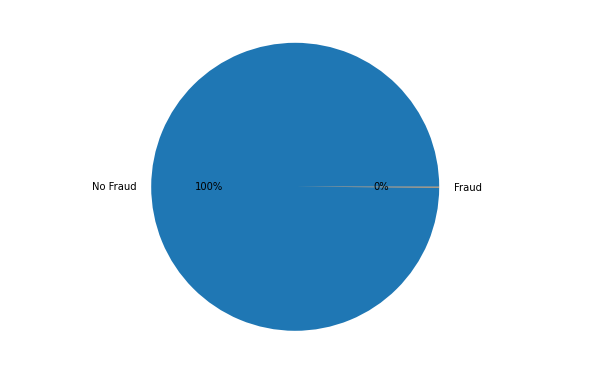

In [159]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['No Fraud', 'Fraud']
target = data.isFraud.value_counts()
ax.pie(target, labels=labels, autopct='%.0f%%')
plt.show()

# Split Dataset

In [160]:
x = np.array(data[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig']])
y = np.array(data[['isFraud']])
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42)

# Treating Outlier With Automatic Outlier Detection

In [161]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()
yhat = lof.fit_predict(xtrain)
mask = yhat != -1
xtrain, ytrain = xtrain[mask,:], ytrain[mask]

# Treating Imbalaced Target Class

In [162]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto', random_state=42)
x_train,y_train = sm.fit_resample(xtrain,ytrain)

In [163]:
s = pd.Series(data=y_train)
s.value_counts()

NO FRAUD    266381
FRAUD       266381
dtype: int64

# Modelling and Evaluation

In [164]:
model=DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(xtest)
print('Training Accuracy : ', model.score(x_train, y_train))
print('Test Accuracy: ', model.score(xtest, ytest))

Training Accuracy :  0.9986785844335745
Test Accuracy:  0.9932266192381799


In [165]:
from sklearn.metrics import confusion_matrix, classification_report
print('Confusion matrix: \n')
cm = confusion_matrix(ytest, y_pred)
print(cm)

Confusion matrix: 

[[   32    11]
 [  446 66981]]


In [166]:
print('classidication report \n')
print(classification_report(ytest, y_pred))

classidication report 

              precision    recall  f1-score   support

       FRAUD       0.07      0.74      0.12        43
    NO FRAUD       1.00      0.99      1.00     67427

    accuracy                           0.99     67470
   macro avg       0.53      0.87      0.56     67470
weighted avg       1.00      0.99      1.00     67470



Now let’s classify whether a transaction is a fraud or not by feeding about a transaction into the model

In [167]:
print('Enter Transactions Details to konw whether that fraud or not')
a = int(input('Enter the type of transactions (1 = CASH OUT, 2 = PAYMENT, 3 = CASH IN, 4 = TRANSFER, 5 = DEBIT):'))
b = int(input('Enter amount of that trasanctions: '))
c = int(input('Enter Balance before transaction: '))
d = int(input('Enter Balance after transaction: '))
features = np.array([[a,b,c,d]])
print('Transactions is ', model.predict(features))

Enter Transactions Details to konw whether that fraud or not
Enter the type of transactions (1 = CASH OUT, 2 = PAYMENT, 3 = CASH IN, 4 = TRANSFER, 5 = DEBIT):4
Enter amount of that trasanctions: 181
Enter Balance before transaction: 181
Enter Balance after transaction: 0
Transactions is  ['FRAUD']
